In [34]:
import warnings
import itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [35]:
data = pd.read_csv('sampled_ts_train.csv', keep_default_na=False)
data['store_grading'].replace({'NULL': 'No Grading'}, inplace = True)
#data['store_grading'].dtype
#data['store_grading'].head()

In [36]:
data.tail()

,store_key,sku_key,tran_date,sales,selling_price,avg_discount,store_region,store_grading,sku_department,sku_subdepartment,sku_category,sku_subcategory
51686,6,35939,2018-01-26,0,59.9,0.0,GTN,A,TY,06,054,092
51687,6,35939,2018-01-27,1,69.9,0.0,GTN,A,TY,06,054,092
51688,6,35939,2018-01-28,0,59.9,0.0,GTN,A,TY,06,054,092
51689,6,35939,2018-01-29,0,59.9,0.0,GTN,A,TY,06,054,092
51690,6,35939,2018-01-30,0,59.9,0.0,GTN,A,TY,06,054,092


## Exploratory Data Analysis

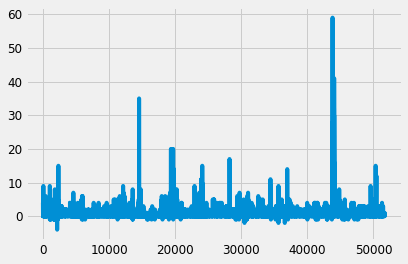

In [37]:
data['sales'].plot()

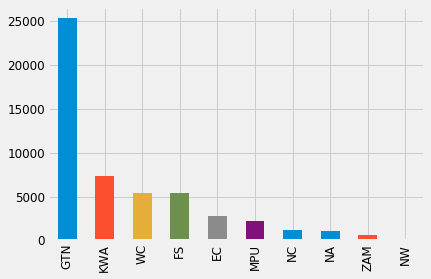

In [38]:
import seaborn as sns
data['store_region'].value_counts().plot(kind='bar')

In [39]:
data['sku_category'].value_counts().sort_values()
data['sku_department'].value_counts()

TY    28678
BC     9707
BH     9416
PM     1799
BY     1611
CF      480
Name: sku_department, dtype: int64

In [40]:
#KWA = data[(data['store_region']=='KWA') & (data['sku_category']=='024')]
#KWA.head()

In [41]:
HighSales = data[data['sku_key'] == 48676]
HighSales.head()

,store_key,sku_key,tran_date,sales,selling_price,avg_discount,store_region,store_grading,sku_department,sku_subdepartment,sku_category,sku_subcategory
43795,115,48676,2017-03-23,2,5.9,0.0,KWA,No Grading,PM,PI,99Z,99R
43796,115,48676,2017-03-24,3,5.9,0.0,KWA,No Grading,PM,PI,99Z,99R
43797,115,48676,2017-03-25,11,5.9,0.0,KWA,No Grading,PM,PI,99Z,99R
43798,115,48676,2017-03-26,6,5.9,0.0,KWA,No Grading,PM,PI,99Z,99R
43799,115,48676,2017-03-27,8,5.9,0.0,KWA,No Grading,PM,PI,99Z,99R


In [42]:
#data.groupby('sku_key').count()['sales'].sort_values(ascending=False)

In [43]:
from datetime import datetime
con=HighSales['tran_date']
HighSales['tran_date']=pd.to_datetime(HighSales['tran_date'])
HighSales.set_index('tran_date', inplace=True)
#check datatype of index
HighSales.index

DatetimeIndex(['2017-03-23', '2017-03-24', '2017-03-25', '2017-03-26',
               '2017-03-27', '2017-03-28', '2017-03-29', '2017-03-30',
               '2017-03-31', '2017-04-01',
               ...
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30'],
              dtype='datetime64[ns]', name='tran_date', length=314, freq=None)

### Exploring the rate of sales of sku_key 48676

In [44]:
#convert to time series:
df = HighSales['sales']
df.head() #Exploring sales in 2016
df.describe()

count    314.000000
mean       5.324841
std        8.092292
min        0.000000
25%        1.000000
50%        2.000000
75%        6.000000
max       59.000000
Name: sales, dtype: float64

In [45]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(HighSales):
    
    #Determing rolling statistics
    rolmean = HighSales.rolling( window=12).mean()
    rolstd = HighSales.rolling( window=12).std()
   # moving_avg = ts_log.rolling(12).mean()

    #Plot rolling statistics:
    orig = plt.plot(HighSales, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(HighSales, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Making data Stationary

Making the mean and variance to remain constant overtime, we are investigating if the mean and standard deviation follows the trends of sales.
Obviously can note that the time series is not stationary since the mean and standard deviation move in the direction of the sales 

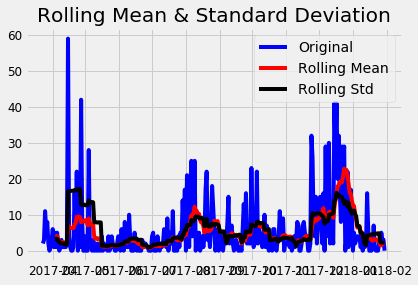

Results of Dickey-Fuller Test:
Test Statistic                  -2.891135
p-value                          0.046389
#Lags Used                      11.000000
Number of Observations Used    302.000000
Critical Value (1%)             -3.452190
Critical Value (5%)             -2.871158
Critical Value (10%)            -2.571895
dtype: float64


In [46]:
test_stationarity(df)
#df.head()

#### Using Logarithmic to reduce the trend
We will be using smoothing method to reduce the trend: Rolling/Moving average

In [47]:
#df_log = np.log(df)
#plt.plot(df)

### Using moving average to reduce the trend

<Figure size 1800x1800 with 0 Axes>

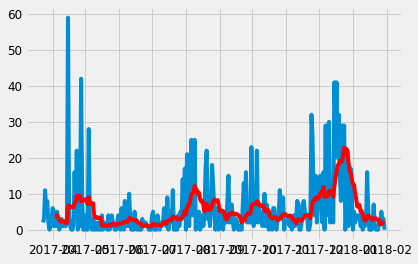

<Figure size 1800x1800 with 0 Axes>

In [48]:
moving_avg = df.rolling(12).mean()
plt.plot(df)
plt.plot(moving_avg, color = 'red')
plt.figure(figsize = (25,25))

Subtracting the rolling mean from the moving average

In [49]:
df_moving_avg_diff = df - moving_avg
df_moving_avg_diff.head(13)

tran_date
2017-03-23         NaN
2017-03-24         NaN
2017-03-25         NaN
2017-03-26         NaN
2017-03-27         NaN
2017-03-28         NaN
2017-03-29         NaN
2017-03-30         NaN
2017-03-31         NaN
2017-04-01         NaN
2017-04-02         NaN
2017-04-03    1.000000
2017-04-04   -2.916667
Name: sales, dtype: float64

In [50]:
df_moving_avg_diff.replace([np.inf, -np.inf], np.nan, inplace = True)

In [51]:
df_moving_avg_diff.dropna(inplace = True)
df_moving_avg_diff.head()

tran_date
2017-04-03    1.000000
2017-04-04   -2.916667
2017-04-05    0.916667
2017-04-06   -1.333333
2017-04-07   -2.833333
Name: sales, dtype: float64

## Testing the stationarity after we used the moving average
we can observe that the mean and variance don't follow any specific trend, but vary slightly with the number of sales


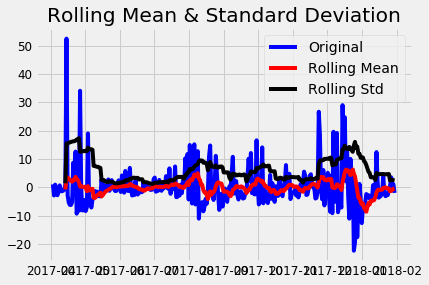

Results of Dickey-Fuller Test:
Test Statistic                  -5.237001
p-value                          0.000007
#Lags Used                      11.000000
Number of Observations Used    291.000000
Critical Value (1%)             -3.453023
Critical Value (5%)             -2.871524
Critical Value (10%)            -2.572090
dtype: float64


In [52]:
test_stationarity(df_moving_avg_diff)

The test statitic shows that we are 95% confident that the series is stationary. Since our test statistic is less than 5%

### Using the exponential weight mean average to decrease our trend further

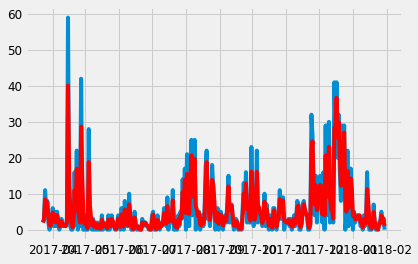

In [53]:
exp_weighted_avg = df.ewm(com=0.5).mean()
plt.plot(df)
plt.plot(exp_weighted_avg, color = 'red')

In [54]:
df_ewma_diff = df - exp_weighted_avg
df_ewma_diff.replace([np.inf, -np.inf], np.nan, inplace = True)
df_ewma_diff.dropna(inplace = True)
df_ewma_diff.head()

tran_date
2017-03-23    0.000000
2017-03-24    0.250000
2017-03-25    2.538462
2017-03-26   -0.800000
2017-03-27    0.396694
Name: sales, dtype: float64

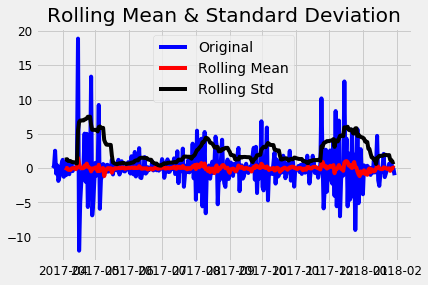

Results of Dickey-Fuller Test:
Test Statistic                -8.163336e+00
p-value                        9.020004e-13
#Lags Used                     1.000000e+01
Number of Observations Used    3.030000e+02
Critical Value (1%)           -3.452118e+00
Critical Value (5%)           -2.871127e+00
Critical Value (10%)          -2.571878e+00
dtype: float64


In [55]:
#df_log_ewma_diff = df_log - exp_weighted_avg
test_stationarity(df_ewma_diff)

## Finally our model is stationary
There are less variations in mean and standard deviation in magnitude
-The test statistic is less than 1%, so we are 99% confident that our time series is staionary

## Now we are looking at seasonality with trend

We will be looking at two methods: Differencing and Decomposition to remove trends with seasonality

## Differencing

In [56]:
df_diff = df - df.shift(1)
df_diff.replace([np.inf, -np.inf], np.nan, inplace = True)
df_diff.dropna(inplace = True)
df_diff.head()

tran_date
2017-03-24    1.0
2017-03-25    8.0
2017-03-26   -5.0
2017-03-27    2.0
2017-03-28   -6.0
Name: sales, dtype: float64

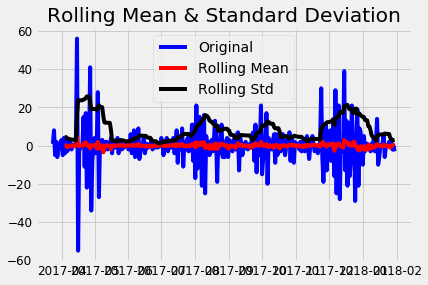

Results of Dickey-Fuller Test:
Test Statistic                -8.224924e+00
p-value                        6.283739e-13
#Lags Used                     1.000000e+01
Number of Observations Used    3.020000e+02
Critical Value (1%)           -3.452190e+00
Critical Value (5%)           -2.871158e+00
Critical Value (10%)          -2.571895e+00
dtype: float64


In [57]:
test_stationarity(df_diff)

We can see that mean and standard deviation have small variations with time, hence stationary

## Seasonal Difference

In [58]:
df_seasonal_difference = df - df.shift(12)
df_seasonal_difference.replace([np.inf, -np.inf], np.nan, inplace = True)
df_seasonal_difference.dropna(inplace = True)
df_seasonal_difference.head()


tran_date
2017-04-04   -1.0
2017-04-05    2.0
2017-04-06   -9.0
2017-04-07   -6.0
2017-04-08   -7.0
Name: sales, dtype: float64

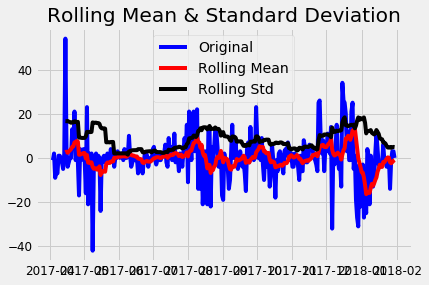

Results of Dickey-Fuller Test:
Test Statistic                  -4.783069
p-value                          0.000059
#Lags Used                      13.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


In [59]:
test_stationarity(df_seasonal_difference)

## Decomposing

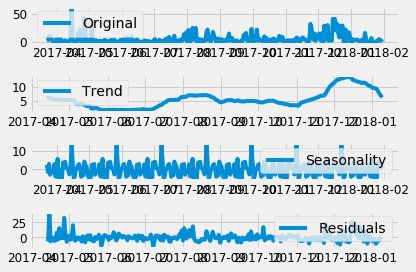

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, freq = 42)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## After removing the trend and seasonality, we have the following graph

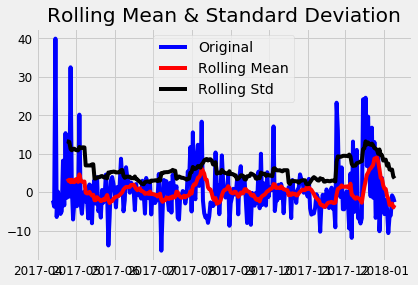

Results of Dickey-Fuller Test:
Test Statistic                  -5.169017
p-value                          0.000010
#Lags Used                       8.000000
Number of Observations Used    263.000000
Critical Value (1%)             -3.455461
Critical Value (5%)             -2.872593
Critical Value (10%)            -2.572660
dtype: float64


In [61]:
df_decompose = residual
df_decompose.dropna(inplace=True)
test_stationarity(df_decompose)

## Forecasting

Plotting the Atocorrelation and Partial correlation to find the optimal parameters

In [62]:
from statsmodels.tsa.stattools import acf, pacf

In [63]:
lag_acf = acf(df_diff, nlags=20)
lag_pacf = pacf(df_diff, nlags=20, method='ols')

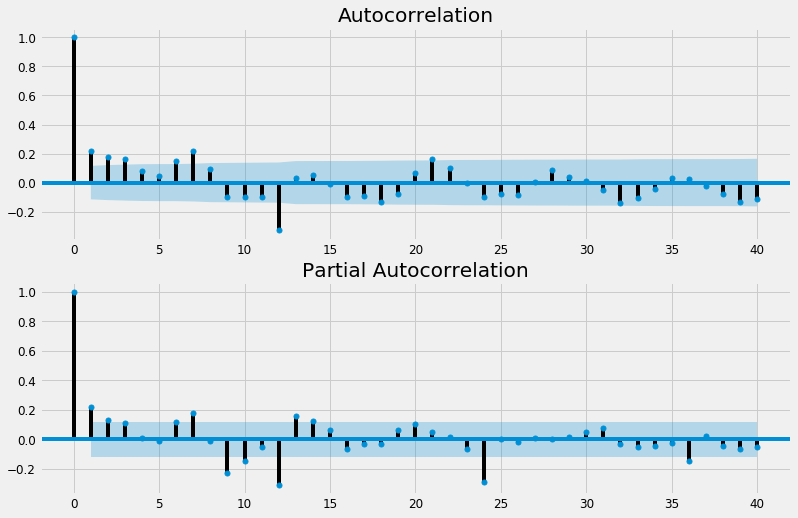

In [64]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_difference.iloc[13:], lags=40, ax=ax2)

# Grid search(Hyperparameter optimization)

In [65]:
from statsmodels.tsa.arima_model import ARIMA

In [66]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [67]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2312.030071082702
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2172.435910157002
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2248.993525406051
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2043.0966129334047
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2164.017055909507
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2146.004222313331
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2112.56885701178
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2045.0721605004871
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2256.832885537082
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2137.9035945940486
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2233.6721390024786
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2023.8073418476595
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2142.9607367408553
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2120.166909651901
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2100.3834961326183
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2025.7900261900372
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2318.1824958724205
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2227.27934014142
ARI

ARIMA(1, 0, 1)x(1, 1, 1, 12) yields the lowest- AIC:1376.914929113491

In [68]:
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=(0,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                  314
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -992.280
Date:                            Mon, 03 Sep 2018   AIC                           1990.561
Time:                                    13:33:16   BIC                           2001.539
Sample:                                03-23-2017   HQIC                          1994.961
                                     - 01-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8344      0.029    -28.855      0.000      -0.891      -0.778
ma.S.L12      -0.8942      0.040   

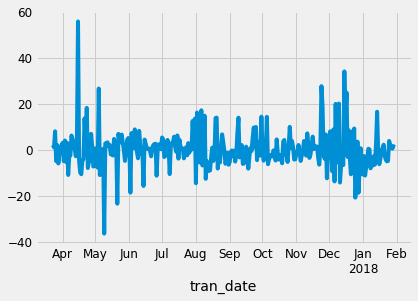

In [69]:
results.resid.plot()


In [70]:
print(results.resid.describe())


count    314.000000
mean       0.036965
std        8.174730
min      -36.525530
25%       -4.211860
50%       -0.261200
75%        2.695178
max       55.833408
dtype: float64


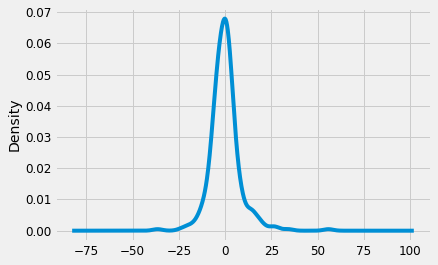

In [71]:
results.resid.plot(kind='kde')


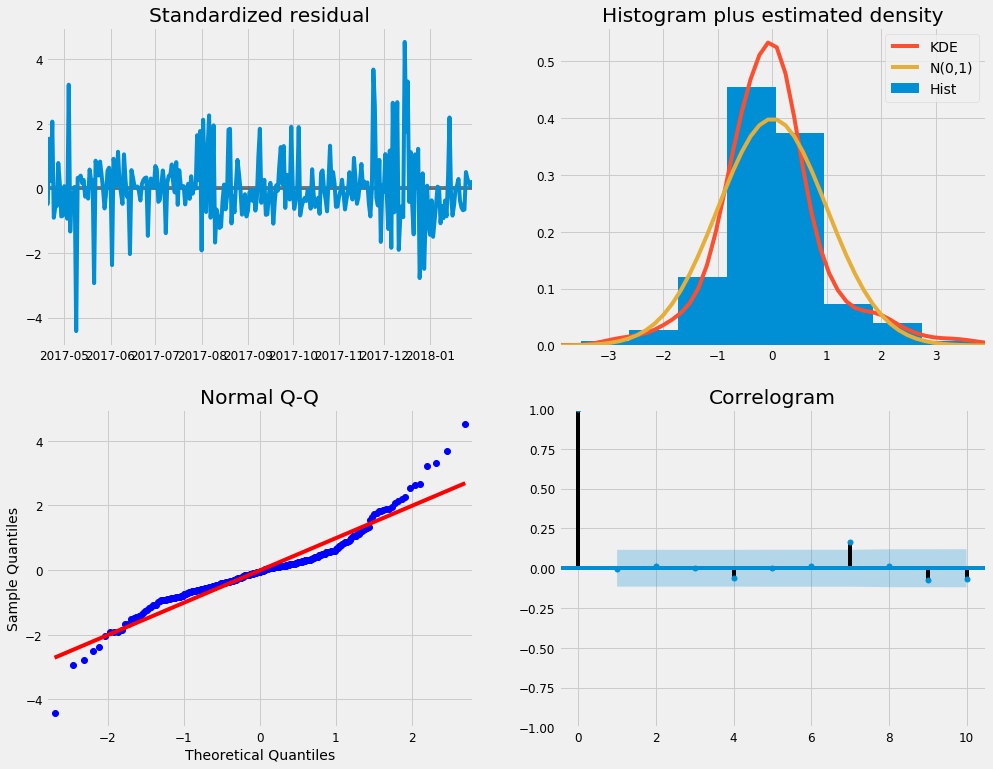

In [72]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [139]:
pred = results.get_prediction(start =300, end = 390, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower sales,upper sales
2018-01-17,-10.755404,18.727702
2018-01-18,-14.539722,14.941688
2018-01-19,-14.380226,15.100846
2018-01-20,-9.933925,19.546914
2018-01-21,-10.946486,18.534189


In [140]:
df_forecast = pred.predicted_mean
df_truth = df['2018-01-01':]

# Compute the mean square error
mse = ((df_forecast - df_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((df_forecast-df_truth)**2)/len(df_forecast))))

The Mean Squared Error (MSE) of the forecast is 8.84
The Root Mean Square Error (RMSE) of the forcast: nan


In [141]:
df_pred_concat = pd.concat([df_truth, df_forecast])


In [142]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-08-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

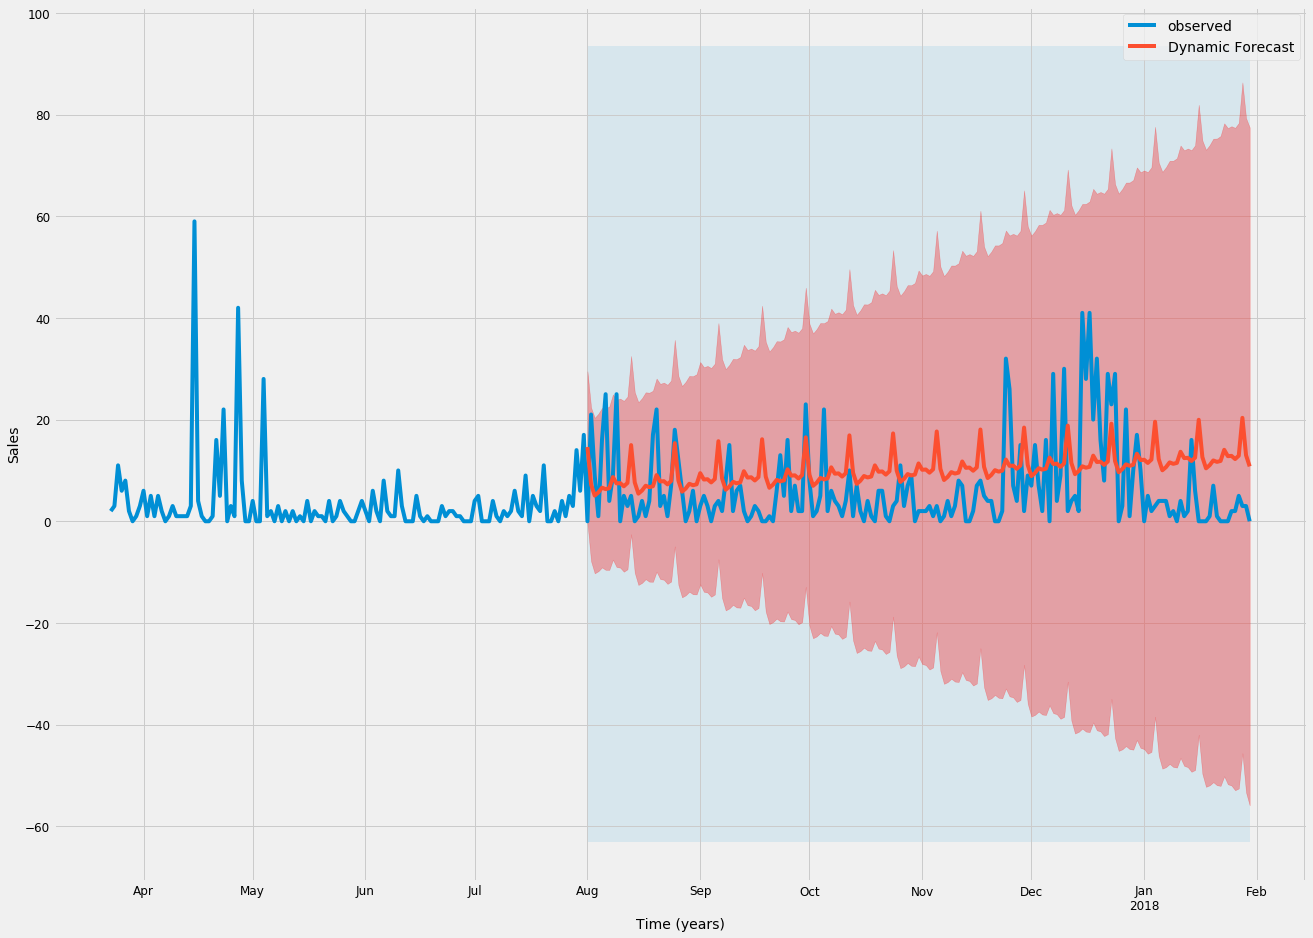

In [143]:
ax = df['2016':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='r', 
                alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2017-08-01'), 
                 df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Sales')

plt.legend()
plt.show()


In [144]:
# Extract the predicted and true values of our time series
df_forecast = pred_dynamic.predicted_mean
df_original = df['2017-08-01':]

# Compute the mean square error
mse = ((df_forecast - df_original) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((df_forecast-df_original)**2)/len(df_forecast))))

The Mean Squared Error (MSE) of the forecast is 88.31
The Root Mean Square Error (RMSE) of the forcast: 9.3972


In [155]:
# Get forecast of 10 years or 90 months steps ahead in future
forecast = results.get_forecast(steps= 90)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

,lower sales,upper sales
2018-01-31,-15.352228,14.126469
2018-02-01,-11.035999,18.844197
2018-02-02,-13.102504,17.173866
2018-02-03,-12.406984,18.260444
2018-02-04,-11.377160,19.676400


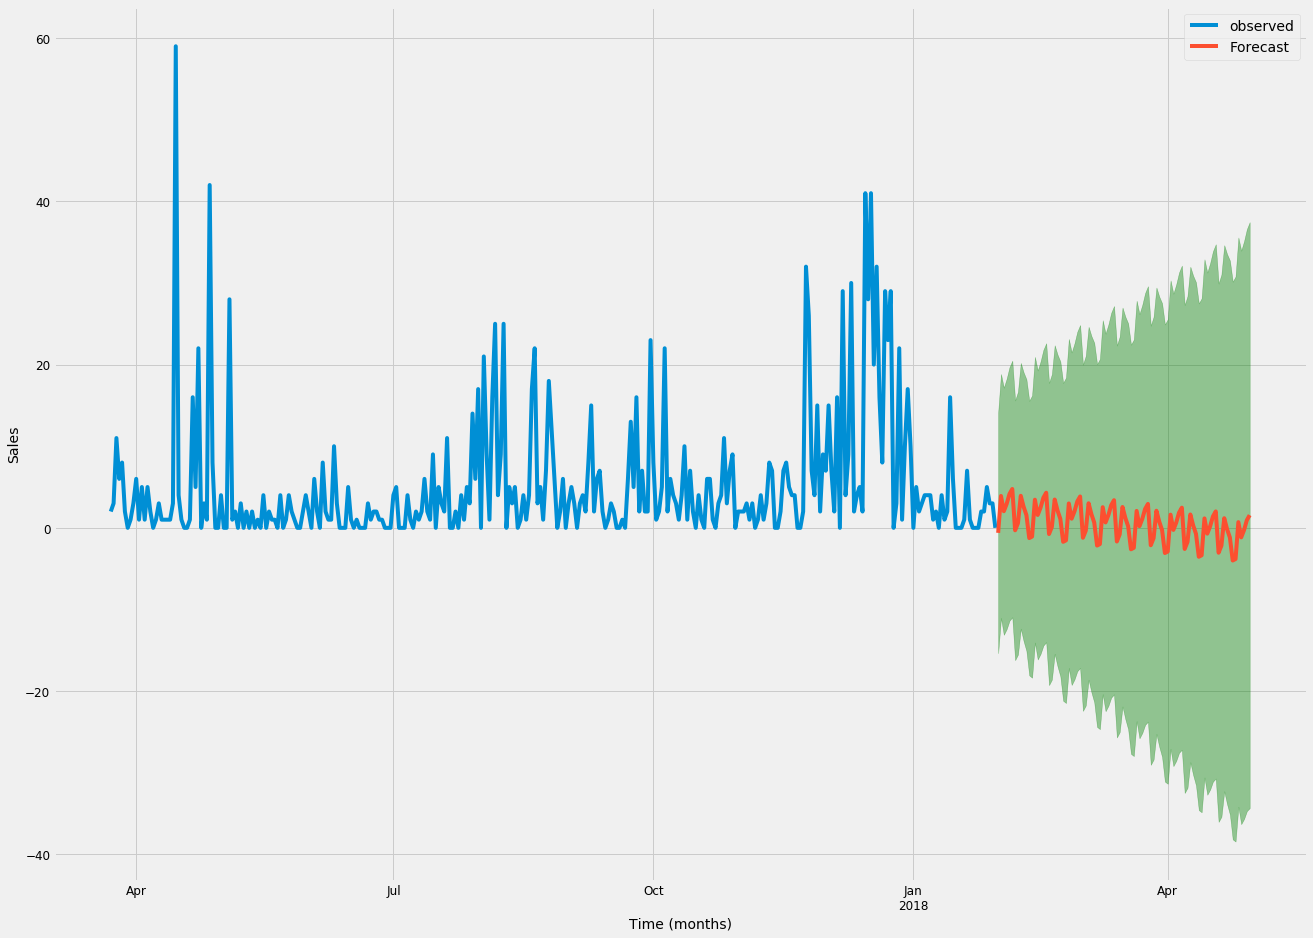

In [157]:
ax = df.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time (months)')
ax.set_ylabel('Sales')

plt.legend()
plt.show()